In [16]:
import numpy as np
import os
import pandas as pd
import arcpy
from pathlib import Path

# Import the required ArcGIS API for Python modules
import arcgis
from arcgis.gis import GIS
gis = arcgis.GIS()
from arcgis.geoanalytics import manage_data

from IPython.display import display, Markdown

In [17]:
rtpSuffix       = 'RTP2023'
dirWork         = os.getcwd()
dirInput        = os.path.join(dirWork , r'input'       )

dirATOdata      = os.path.join(dirInput, r'TDM_ATO_Output_RTP_v900') # This folder should contain a copy of all the TDM ATO outputs from the latest official version
dirIntermediate = os.path.join(dirWork , r'intermediate'           ) # This is a temporary folder where intermediate datasets are stored for use in preppring the results
dirResults      = os.path.join(dirWork , r'results'                ) # This is the folder where all the results will be saved
dirWebAppData   = os.path.join(str(Path(dirWork).parents[0]), r'widgets\ATOSidebar\data') # This is the folder where all the web data (non-AGOL) will go


print("Working Directory: "      + dirWork   )
print("Input Directory: "        + dirInput  )
print("Intermediate Directory: " + dirIntermediate  )
print("Results Directory: "      + dirResults)
print("Web App Data Directory: " + dirWebAppData)

# These are the groups of TAZs for which ATO scores will be averaged and to which calculated relative
filenameTAZSmallArea2019     = os.path.join(dirInput, r"ATONewSmallAreas.gdb\TAZSmallArea2019") # This file contains a polygon for each small area for which average ATOs will be calculated
filenamePOMSmallArea         = os.path.join(dirInput, r"POTM_ATOMaps.gdb\POTM_AreaOutline"    ) # This file contains a polygon for the point of the mountain area, which overlaps the small areas

# this gdb will be programatically created and results will be stored here
gdb_ATO      = 'ATO_' + rtpSuffix + '.gdb'
gdb_ATO_Path = os.path.join(dirResults, gdb_ATO)

filenameTDMNodes     = os.path.join(dirATOdata     , r'v9_RTP_SE50_Net50_Node.shp'     ) # this is a copy of the the node shapefile created in the 2050 model run input processing directory
filenameTAZshp       = os.path.join(dirResults     , r'TAZ_ATO_' + rtpSuffix + '.shp'  ) # This file is a copy of the taz shapefile with all the TAZs and only the TAZID and CO_TAZID fields.
filenameAreasATO     = os.path.join(dirResults     , r'Areas_ATO_' + rtpSuffix + '.shp') # Output file for Areas

# This should return filename for TDM output that is copied into the input data
def getCSVFilename(year):
    return os.path.join(dirATOdata, 'Access_to_Opportunity_' + str(year) + '.csv')

#list of anlysis years
listYear     = [2023,2032,2042,2050,2050]

# these are the years from which the average is used to divide by for comparison
listAvgYear  = [2023,2032,2042,2050,2023]

#list for which gains will be calculated [Base,Future]
#listGain     = [[2023,2032],
#                [2023,2042],
#                [2023,2050]]
listGain     = [[2023,2050]]

#FIELD NAME IS FORMATTED LIKE THIS: {CATEGORY}By{MODE}

#list of all categories to be used in app (by field name convention)
listCategory = ['HH','Job','CompJobHH']

#list of all modes (by field name convention)
listMode     = ['Auto','Tran']

#bins for display of percent of average
listBins = [-np.inf, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, np.inf]

listBinData  = {
                'Color'       : ["#31398a"      , "#1ba9e6"   , "#00a74e"   , "#6cb74a"       , "#8dc348"        , "#E09d2e"     , "#Eb672d"     , "#E5272d"     , "#Af2944"           ],
                'Description' : ["Less than 40%", "40% to 60%", "60% to 80%", "80% to Average", "Average to 120%", "120% to 140%", "140% to 160%", "160% to 180%", "Greather than 180%"]
} 

dfBinData = pd.DataFrame(listBinData)
dfBinData.to_json(os.path.join(dirWebAppData, "bindata.json"),orient='records',double_precision=2)

highestTazID = 3546


Working Directory: e:\GitHub\ATO-Web-App\_dataprep
Input Directory: e:\GitHub\ATO-Web-App\_dataprep\input
Intermediate Directory: e:\GitHub\ATO-Web-App\_dataprep\intermediate
Results Directory: e:\GitHub\ATO-Web-App\_dataprep\results
Web App Data Directory: e:\GitHub\ATO-Web-App\widgets\ATOSidebar\data


In [18]:
filenameTAZSmallArea2019_shp = os.path.join(dirIntermediate, "TAZSmallArea2019.shp")
filenamePOMSmallArea_shp     = os.path.join(dirIntermediate, "POTM_AreaOutline.shp")

def deleteIfExists(obj):
    if arcpy.Exists(obj): arcpy.Delete_management(obj)
    
#export to shp files for better drawing in Jupyter

deleteIfExists(filenameTAZSmallArea2019_shp)
print ("Exporting " + filenameTAZSmallArea2019_shp + "...")
arcpy.conversion.FeatureClassToShapefile(filenameTAZSmallArea2019, dirIntermediate)

deleteIfExists(filenamePOMSmallArea_shp)
print ("Exporting " + filenamePOMSmallArea_shp + "...")
arcpy.conversion.FeatureClassToShapefile(filenamePOMSmallArea, dirIntermediate)


#if results geodatabase doesn't exist, create it
print("Checking if " + gdb_ATO + " exists...")
if not arcpy.Exists(os.path.join(dirResults, gdb_ATO)):
    print("Creating " + gdb_ATO + "...")
    arcpy.management.CreateFileGDB(dirResults, gdb_ATO)
else:
    print(gdb_ATO + " exists...")

#print(AnalysisAreasInput)

Exporting e:\GitHub\ATO-Web-App\_dataprep\intermediate\TAZSmallArea2019.shp...
Exporting e:\GitHub\ATO-Web-App\_dataprep\intermediate\POTM_AreaOutline.shp...
Checking if ATO_RTP2023.gdb exists...
ATO_RTP2023.gdb exists...


In [19]:
sdfTAZCentroids = pd.DataFrame.spatial.from_featureclass(filenameTDMNodes)

#filter by nodes with N<2881 (max centroid #)
sdfTAZCentroids = sdfTAZCentroids[sdfTAZCentroids['N']<=highestTazID]

display(sdfTAZCentroids)

sdfSmallAreas   = pd.DataFrame.spatial.from_featureclass(filenameTAZSmallArea2019_shp)
sdfPOTMArea     = pd.DataFrame.spatial.from_featureclass(filenamePOMSmallArea_shp    )

#limit dataframe to just 3 columns and rename
sdfSmallAreas   = sdfSmallAreas[['SAID','NewSA','SHAPE']]
sdfSmallAreas.columns = ('SAID','SANAME','SHAPE')

#display(sdfSmallAreas)

#give POTM polygon SAID and SANAME
sdfPOTMArea['SAID'  ] = 'POTM'
sdfPOTMArea['SANAME'] = 'Point of the Mountain'

#limit dataframe to just 3 columns
sdfPOTMArea = sdfPOTMArea[['SAID','SANAME','SHAPE']]

#display(sdfPOTMArea)
sdfAreas = pd.concat([sdfSmallAreas, sdfPOTMArea])

sdfAreas = sdfAreas.reset_index()

sdfAreas = sdfAreas[['SAID','SANAME','SHAPE']]

display(sdfAreas)

FID     N            X            Y  TAZID  CBD  COUNTY  CO_TAZID  \
0        0     1  411935.0000  4605642.000      1    0       0     30001   
1        1     2  412641.0000  4606013.000      2    0       0     30002   
2        2     3  408993.0000  4603544.000      3    0       0     30003   
3        3     4  410051.0000  4604806.000      4    0       0     30004   
4        4     5  413394.0000  4603600.000      5    0       0     30005   
...    ...   ...          ...          ...    ...  ...     ...       ...   
3541  3541  3542  437855.5279  4416554.399   3542    0       0    491326   
3542  3542  3543  446638.1409  4416718.254   3543    0       0    491327   
3543  3543  3544  459846.2738  4423353.587   3544    0       0    491328   
3544  3544  3545  479974.8910  4421200.446   3545    0       0    491329   
3545  3545  3546  495028.6909  4414343.628   3546    0       0    491330   

      CO_FIPS    CO_NAME  ...  OFFI  GVED HLTH  OTHR AGRI  MING  CONS HBJ  \
0           3  BOX ELDER  ...     0     0    0     0    0     0     0   0   
1           3  BOX ELDER  ...     0     0    0     0    0     0    10   2   
2           3  BOX ELDER  ...     0     0    0     0    0     0     2   1   
3           3  BOX ELDER  ...     0     0    0     0    0     0     1   0   
4           3  BOX ELDER  ...     0     1    4     2    0     0     7   4   
...       ...        ...  ...   ...   ...  ...   ...  ...   ...   ...  ..   
3541       49       UTAH  ...     0     0    0     0    0     0     0   0   
3542       49       UTAH  ...     0     0    0     0    0     0     0   0   
3543       49       UTAH  ...     0     0    0     0    0     0     0   0   
3544       49       UTAH  ...     0     0    0     0    0     0     0   0   
3545       49       UTAH  ...     0     0    0     0    0     0     0   0   

      TranStop                                              SHAPE  
0            0  {"x": 411935, "y": 4605642, "spatialReference"...  
1            0  {"x": 412641, "y": 4606013, "spatialReference"...  
2            0  {"x": 408993, "y": 4603544, "spatialReference"...  
3            0  {"x": 410051, "y": 4604806, "spatialReference"...  
4            0  {"x": 413394, "y": 4603600, "spatialReference"...  
...        ...                                                ...  
3541         0  {"x": 437855.5279, "y": 4416554.399, "spatialR...  
3542         0  {"x": 446638.1409, "y": 4416718.254, "spatialR...  
3543         0  {"x": 459846.2738, "y": 4423353.587, "spatialR...  
3544         0  {"x": 479974.891, "y": 4421200.446, "spatialRe...  
3545         0  {"x": 495028.6909, "y": 4414343.628, "spatialR...  

[3546 rows x 49 columns]

SAID                      SANAME  \
0     BE            Box Elder (WFRC)   
1     CU         Central Utah County   
2     ND          North Davis County   
3    NSL      North Salt Lake County   
4     NU           North Utah County   
5     NW          North Weber County   
6     SD          South Davis County   
7     SU           South Utah County   
8     SW          South Weber County   
9   SESL  Southeast Salt Lake County   
10  SWSL  Southwest Salt Lake County   
11  POTM       Point of the Mountain   

                                                SHAPE  
0   {"rings": [[[-12472581.3825, 5100247.255000003...  
1   {"rings": [[[-12440222.2273, 4928727.495999999...  
2   {"rings": [[[-12466479.0624, 5035031.498899996...  
3   {"rings": [[[-12463143.5911, 4989089.138499998...  
4   {"rings": [[[-12442943.7757, 4937264.529899999...  
5   {"rings": [[[-12465838.0385, 5064111.556500003...  
6   {"rings": [[[-12457822.365899999, 5020313.9883...  
7   {"rings": [[[-12426300.0459, 4894985.916599996...  
8   {"rings": [[[-12461509.6502, 5055608.677699998...  
9   {"rings": [[[-12449889.3309, 4966298.7007], [-...  
10  {"rings": [[[-12458760.494199999, 4966079.2286...  
11  {"rings": [[[-12452867.7948, 4956621.984999999...

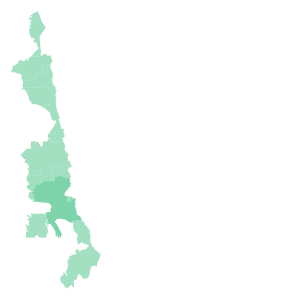

In [20]:
sdfAreas.spatial

In [21]:
#create map centered on Salt Lake
map_areas = gis.map('Salt Lake')

#define sdf layer
sdfAreas.spatial.plot(map_widget = map_areas,
                            renderer_type='s',
                            cmap = 'RdPu',  # use a red to purple color map
                            symbol_type='simple',
                            outline_style='s',
                            outline_color=[0,0,0,255],
                            line_width=1.0)

#display map
map_areas

MapView(layout=Layout(height='400px', width='100%'))

In [22]:
#verify that shape exists and sdf was created correctly and get spatial reference
print("sdfAreas: " + str(sdfAreas.iloc[0].SHAPE.spatialReference['latestWkid']))
print("TAZCentroids: " + str(sdfTAZCentroids.iloc[0].SHAPE.spatialReference['latestWkid']))

#change projection to 26912 (EPSG:26912 - NAD83 / UTM zone 12N)
if (sdfAreas.iloc[0].SHAPE.spatialReference['latestWkid'])!=26912:
    sdfAreas.spatial.project(26912)
    print("sdfAreas: " + str(sdfAreas.iloc[0].SHAPE.spatialReference['latestWkid']))

if (sdfAreas.iloc[0].SHAPE.spatialReference['latestWkid'])!=26912:
    sdfAreas.spatial.project(26912)
    print("TAZCentroids: " + str(sdfTAZCentroids.iloc[0].SHAPE.spatialReference['latestWkid']))


sdfAreas: 3857
TAZCentroids: 26912
sdfAreas: 26912


In [23]:
# export areas
sdfAreas.spatial.to_featureclass(filenameAreasATO, sanitize_columns=False)

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\Areas_ATO_RTP2023.shp'

In [24]:
sdfTAZa = sdfTAZCentroids.spatial.join(sdfAreas)
dfTAZa = sdfTAZa[['TAZID','SAID']]
#dfTAZa = dfTAZa.rename(columns={"N": "TAZID"})

# create copy for whole region
dfRegion = pd.DataFrame (dfTAZa['TAZID'].unique(),columns=['TAZID'])
dfRegion['SAID'] = 'REGION'

dfTAZa = pd.concat([dfTAZa,dfRegion])

listSA   = dfTAZa['SAID'].unique()

display(dfTAZa)
display(listSA)

TAZID    SAID
0         1      BE
1         2      BE
2         3      BE
3         4      BE
4         5      BE
...     ...     ...
3396   3479  REGION
3397   3480  REGION
3398   3481  REGION
3399   3482  REGION
3400   3483  REGION

[7513 rows x 2 columns]

array(['BE', 'NW', 'SW', 'ND', 'SD', 'NSL', 'SWSL', 'POTM', 'SESL', 'NU',
       'CU', 'SU', 'REGION'], dtype=object)

In [25]:
#check TAZ 2104 in overlapping areas 
display(dfTAZa.loc[dfTAZa['TAZID'] == 2104])

TAZID    SAID
2127   2104    POTM
2796   2104    SESL
1955   2104  REGION

In [26]:
def unique(list1):
    # intilize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list

In [27]:
display(unique(listAvgYear))

[2023, 2032, 2042, 2050]

In [28]:
#calculate averages
dfAvg = pd.DataFrame()

sdfTAZ = pd.DataFrame.spatial.from_featureclass(filenameTAZshp)

for y, year in enumerate(unique(listAvgYear)):
    #display(year)
    
    dfATO = pd.read_csv(getCSVFilename(year))
    
    #display(dfATO)
    
    for mode in listMode:
        for category in listCategory:
            #display(str(year) + '_' + mode + "_" + category)
            
            dfATOf = dfATO[['TAZID', category + 'By' + mode]].copy()
            dfATOf.columns = ("Z","V")
            
            dfATOf.columns = ("TAZID","VALUE")
                        
            dfATOf['LABEL'] = round(dfATOf['VALUE'] / 1000,0).astype(int).astype('str') + "k"
            
            #display(dfATOf)
            
            dfTAZa_ATOf = pd.DataFrame.merge(dfTAZa,dfATOf,on="TAZID")
                        
            dfSAa = dfTAZa_ATOf.groupby(['SAID'], as_index=False).agg({"TAZID":[np.size],"VALUE":[np.mean]})
            dfSAa.columns = ('SAID','TAZCNT','AVG')
            
            dfSAa['AVG'] = dfSAa['AVG'].astype('int64')
            
            #display(dfSAa)
            #display(dfATOf_SAa.describe())
            
            for sa in listSA: 
                
                saAvg = dfSAa[dfSAa['SAID']==sa]['AVG'].values[0]
                
                dfAvg = dfAvg.append({'Name'           : ('RTP2023_YEAR_' + str(year) + '_' + mode + '_' + category + '_' + sa).upper(),
                                      'Average'        :  saAvg
                                     },ignore_index=True)

In [29]:
dfAvg[dfAvg['Name'].str.contains('POTM')]

Name   Average
7           RTP2023_YEAR_2023_AUTO_HH_POTM  134629.0
20         RTP2023_YEAR_2023_AUTO_JOB_POTM  240945.0
33   RTP2023_YEAR_2023_AUTO_COMPJOBHH_POTM  194932.0
46          RTP2023_YEAR_2023_TRAN_HH_POTM    2462.0
59         RTP2023_YEAR_2023_TRAN_JOB_POTM    7042.0
72   RTP2023_YEAR_2023_TRAN_COMPJOBHH_POTM    4717.0
85          RTP2023_YEAR_2032_AUTO_HH_POTM  168272.0
98         RTP2023_YEAR_2032_AUTO_JOB_POTM  278287.0
111  RTP2023_YEAR_2032_AUTO_COMPJOBHH_POTM  234683.0
124         RTP2023_YEAR_2032_TRAN_HH_POTM    2910.0
137        RTP2023_YEAR_2032_TRAN_JOB_POTM    7975.0
150  RTP2023_YEAR_2032_TRAN_COMPJOBHH_POTM    5278.0
163         RTP2023_YEAR_2042_AUTO_HH_POTM  199801.0
176        RTP2023_YEAR_2042_AUTO_JOB_POTM  310351.0
189  RTP2023_YEAR_2042_AUTO_COMPJOBHH_POTM  266525.0
202         RTP2023_YEAR_2042_TRAN_HH_POTM    3483.0
215        RTP2023_YEAR_2042_TRAN_JOB_POTM    8584.0
228  RTP2023_YEAR_2042_TRAN_COMPJOBHH_POTM    5919.0
241         RTP2023_YEAR_2050_AUTO_HH_POTM  227319.0
254        RTP2023_YEAR_2050_AUTO_JOB_POTM  333539.0
267  RTP2023_YEAR_2050_AUTO_COMPJOBHH_POTM  292044.0
280         RTP2023_YEAR_2050_TRAN_HH_POTM    7395.0
293        RTP2023_YEAR_2050_TRAN_JOB_POTM   16569.0
306  RTP2023_YEAR_2050_TRAN_COMPJOBHH_POTM   11983.0

In [30]:
for y, year in enumerate(listYear):
    display(year)
    
    dfATO = pd.read_csv(getCSVFilename(year))
    
    #display(dfATO)
    
    for mode in listMode:
        for category in listCategory:
            #display(str(year) + '_' + mode + "_" + category)
            
            strName = ('RTP2023_YEAR_' + str(year) + '_AVG_' + str(listAvgYear[y]) + '_' + mode + '_' + category).upper()
            
            dfATOf = dfATO[['TAZID', category + 'By' + mode]].copy()
            dfATOf.columns = ("Z","V")
            
            #export df to json to use in chart prep
            dfATOf.to_json(os.path.join(dirWebAppData, strName + ".json"),orient='records',double_precision=0)

            dfATOf.columns = ("TAZID","VALUE")
                        
            dfATOf['LABEL'] = round(dfATOf['VALUE'] / 1000,0).astype(int).astype('str') + "k"
                       
            for sa in listSA: 
                
                #strName = 'RTP2023_YEAR_' + str(year) + '_' + mode + '_' + category + '_' + sa + '.json'
                #display(strName)
                
                #get average from average year                
                _avgname = ('RTP2023_YEAR_' + str(listAvgYear[y]) + '_' + mode + '_' + category + '_' + sa).upper()
                #display(_avgname)
                
                saAvg = dfAvg[dfAvg['Name']==_avgname].Average.sum() #use sum to get value, but should be only one record
                                        
                #display(saAvg)
                
                #dfATOf['PCT_' + sa] = dfATOf['VALUE'] / saAvg
                #dfATOf['BIN_' + sa] = pd.cut(dfATOf['PCT_' + sa], listBins, labels=False)                
                
                dfATOf['AVG_' + sa] = saAvg
                dfATOf['BIN_' + sa] = pd.cut(dfATOf['VALUE'] / saAvg, listBins, labels=False)
                
                #dfExport = dfATOf[['CO_TAZID','BIN','LABEL']].copy()
                #dfExport.columns = ('Z','B','L')
                #display(dfExport)
                
                #dfExport.to_json(os.path.join(dirResults, strName),orient='records',double_precision=2)
                
            #display(dfATOf)
            
            sdfTAZATO = pd.DataFrame.merge(sdfTAZ,dfATOf,on="TAZID")
            filename = (gdb_ATO_Path + '\\' + strName)

            deleteIfExists(filename)
            display(filename)
            sdfTAZATO.spatial.to_featureclass(filename, sanitize_columns=False)
            

2023

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2023_AVG_2023_AUTO_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2023_AVG_2023_AUTO_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2023_AVG_2023_AUTO_COMPJOBHH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2023_AVG_2023_TRAN_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2023_AVG_2023_TRAN_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2023_AVG_2023_TRAN_COMPJOBHH'

2032

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2032_AVG_2032_AUTO_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2032_AVG_2032_AUTO_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2032_AVG_2032_AUTO_COMPJOBHH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2032_AVG_2032_TRAN_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2032_AVG_2032_TRAN_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2032_AVG_2032_TRAN_COMPJOBHH'

2042

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2042_AVG_2042_AUTO_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2042_AVG_2042_AUTO_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2042_AVG_2042_AUTO_COMPJOBHH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2042_AVG_2042_TRAN_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2042_AVG_2042_TRAN_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2042_AVG_2042_TRAN_COMPJOBHH'

2050

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2050_AUTO_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2050_AUTO_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2050_AUTO_COMPJOBHH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2050_TRAN_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2050_TRAN_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2050_TRAN_COMPJOBHH'

2050

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2023_AUTO_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2023_AUTO_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2023_AUTO_COMPJOBHH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2023_TRAN_HH'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2023_TRAN_JOB'

'e:\\GitHub\\ATO-Web-App\\_dataprep\\results\\ATO_RTP2023.gdb\\RTP2023_YEAR_2050_AVG_2023_TRAN_COMPJOBHH'

In [31]:
for gain in listGain:
    display(gain)
    
    year_B = gain[0]
    year_F = gain[1]
    
    dfATO_B = pd.read_csv(getCSVFilename(year_B))
    dfATO_F = pd.read_csv(getCSVFilename(year_F))
    
    #display(year_B)
    #display(dfATO_B)
    #display(year_F)
    #display(dfATO_F)
    
    for mode in listMode:
        for category in listCategory:
            
            strName = ('RTP2023_GAIN_' + str(year_B) + 'TO' + str(year_F) + '_' + mode + "_" + category).upper()
            
            dfATOf_B = dfATO_B[['TAZID', category + 'By' + mode]]
            dfATOf_F = dfATO_F[['TAZID', category + 'By' + mode]]

            dfATOf_B.columns = ('TAZID','VALUE_B')
            dfATOf_F.columns = ('TAZID','VALUE_F')
            
            dfATOf_G = pd.DataFrame.merge(dfATOf_B,dfATOf_F,on='TAZID')
            dfATOf_G['VALUE'   ]  =  dfATOf_G['VALUE_F'] - dfATOf_G['VALUE_B']
            #dfATOf_G['VALUEPER'] = (dfATOf_G['VALUE_F'] - dfATOf_G['VALUE_B']) / dfATOf_G['VALUE_B'] * 100
            
            dfATOf_G['LABEL']    = round(dfATOf_G['VALUE']   / 1000,0).astype(int).astype('str') + "k"
            #dfATOf_G['LABELPER'] = round(dfATOf_G['VALUEPER']      ,0).astype(int).astype('str') + "%"
            
            #compute gains
            dfTAZa_ATOf_G = pd.DataFrame.merge(dfTAZa,dfATOf_G,on='TAZID')
            
            dfSAa = dfTAZa_ATOf_G.groupby(['SAID'], as_index=False).agg({"TAZID":[np.size],"VALUE":[np.mean]})
            dfSAa.columns = ('SAID','TAZCNT','AVG')
            
            dfSAa['AVG'] = dfSAa['AVG'].astype('int64')
            
            #display(dfATOf_SAa)
            #display(dfATOf_SAa.describe())
            
            for sa in listSA: 
                
                saAvg     = dfSAa[dfSAa['SAID']==sa]['AVG'   ].values[0]
                #saAvgPer = dfSAa[dfSAa['SAID']==sa]['AVGPER'].values[0]
                
                dfAvg = dfAvg.append({'Name'           : ('RTP2023_GAIN_' + str(year_B) + 'to' + str(year_F) + '_' + mode + '_' + category + '_' + sa).upper(),
                                      'Average'        :  saAvg
                                     },ignore_index=True)
                #display(saAvg)
            
                dfATOf_G['BIN_'     + sa] = pd.cut(dfATOf_G['VALUE'   ] / saAvg   , listBins, labels=False)
                #dfATOf_G['BINPER_' + sa] = pd.cut(dfATOf_G['VALUEPER'] / saAvgPer, listBins, labels=False)
                
                #dfExport = dfATOf_G[['TAZID','BIN','LABEL']]
                #dfExport.columns = ('Z','B','L')
                #display(dfExport)
                
                #dfExport.to_json(os.path.join(dirResults, strName),orient='records',double_precision=2)
                        
            sdfTAZATO = pd.DataFrame.merge(sdfTAZ,dfATOf_G,on="TAZID")
            filename = (gdb_ATO_Path + '\\' + strName)
            deleteIfExists(filename)
            sdfTAZATO.spatial.to_featureclass(filename, sanitize_columns=False)
            

[2023, 2050]

In [32]:
dfAvg.to_json(os.path.join(dirWebAppData, "averagevalues.json"),orient='records',double_precision=0)

In [33]:
#create map centered on Salt Lake
map_ato = gis.map('Salt Lake')

#define sdf layer
sdfTAZATO.spatial.plot(map_widget = map_ato,
                            renderer_type='s',
                            cmap = 'RdPu',  # use a red to purple color map
                            symbol_type='simple',
                            outline_style='s',
                            outline_color=[0,0,0,255],
                            line_width=1.0)

#display map
map_ato

MapView(layout=Layout(height='400px', width='100%'))